In [1]:
# from __future__ import absolute_import, division, print_function
import os
import numpy as np
import numpy.random as npr
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
# import json
# import re
import matplotlib.pyplot as plt
import csv

from pathlib import Path
import dotenv
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rules_dict #rule_name
from network import Model
import tools
from tools_lnd import make_FP_axs, gen_D_fp_qr, gen_mov_trial_set, plot_training_history, plot_var_x_epoch
from tools_lnd import interp3d, take_names, find_fp_dst_subspaces, plot_var_in, var_x_epoch

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################

epoch_set_master = ['stim1','stim1']
fig_name = 'fig2'
figpath = os.path.join(p_code,'figs',fig_name,'fig2_ACEGI')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
# ##################################################################
# #Find right model dir
# ##################################################################

rule_trains = ['delaygo','delayanti']
ruleset = 'mem_motifs_small'
file = 'LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0'
m = os.path.join(p_data,fig_name,file)


Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instea

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2024-04-15 09:19:29.487633: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


<Figure size 1000x500 with 0 Axes>

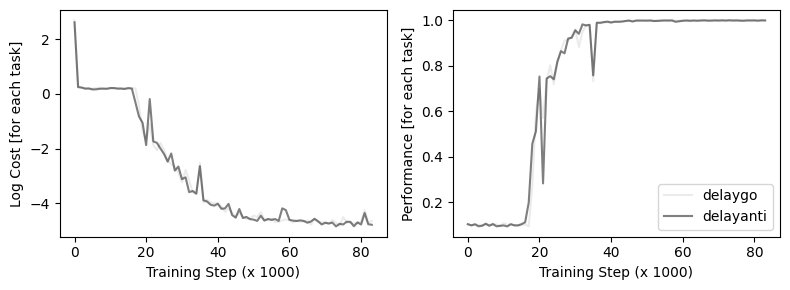

In [4]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    # sigma_rec = 0#hparams['sigma_rec']
    # dt = hparams['dt']
    # tau = hparams['tau']
    # alpha = dt/tau
    # activation = hparams['activation']

# if activation == 'softplus':
#     _activation = lambda x: np.log(np.exp(x) + 1)
# elif activation == 'tanh':
#     _activation = lambda x: np.tanh(x)
# elif activation == 'relu':
#     _activation = lambda x: x * (x > 0)
# elif activation == 'power':
#     _activation = lambda x: (x * (x > 0))**2
# elif activation == 'retanh':
#     _activation = lambda x: np.tanh(x * (x > 0))

# def out_affine(params, h):
#     offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
#     return np.dot(params[2].T,h)+offset

# def relu(x):
#     f = x * (x > 0)
#     return f

# def rnn_vanilla(params, h, x, alpha):
#     alpha = .2
#     xh = np.concatenate([x,h], axis=0)
#     gate_inputs = np.dot(params[0].T,xh)+params[1]
#     noise = 0
#     output = _activation(gate_inputs) # + noise
    
# #     print(type(alpha),type(h),type(output))

#     h_new = (1-alpha) * h + alpha * output
    
#     return h_new

# def vanilla_run_with_h0(params, x_t, h0, alpha):
#     h = h0
#     h_t = []
#     h_t.append(np.expand_dims(h0,axis=1))
#     for x in x_t:
#         h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
#         h_t.append(np.expand_dims(h,axis=1))

#     h_t = np.squeeze(np.array(h_t))  
#     return h_t

# def vanilla_run_at_fp(params, x_t, h0, alpha):
#     h = h0
#     h_t = []
#     h_t.append(h)
#     for x in x_t:
#         h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
#         h_t.append(np.expand_dims(h,axis=1))
        
#     return h_t

plot_training_history(m,hparams['rule_trains'])

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:515: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,marker = 'x',


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2998: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2998: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


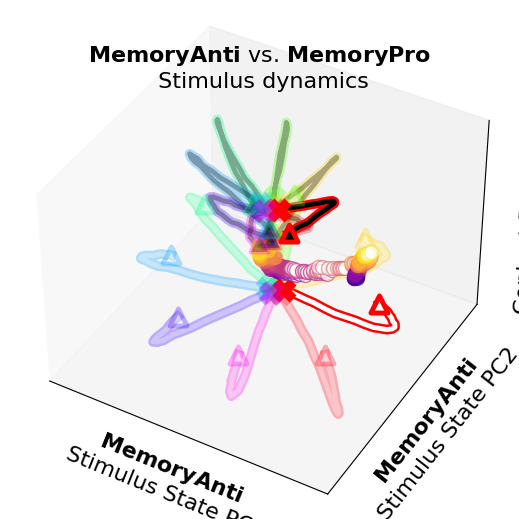

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


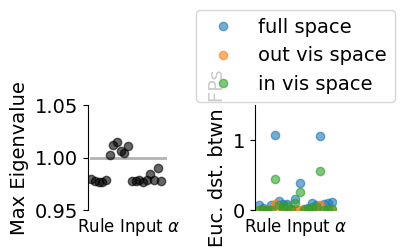

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' sha

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:515: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,marker = 'x',


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2998: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2998: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')


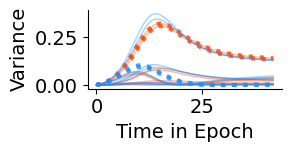

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


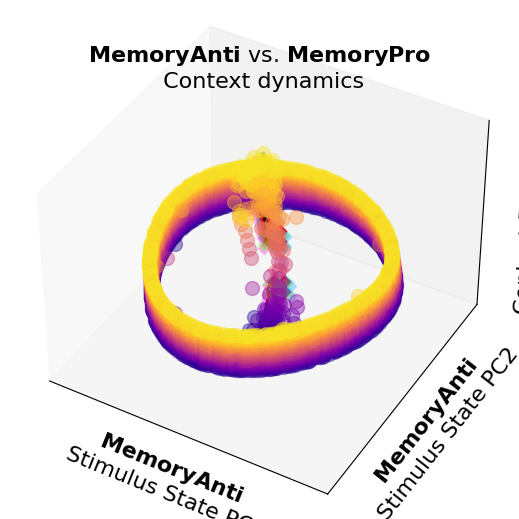

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


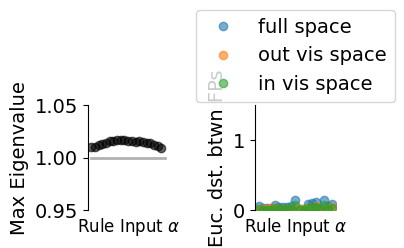

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Rest

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig2/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_delayanti_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' sha

In [ ]:


interp = True
fig_size = 5
linestyle = ['-','-']
tol_q = 1e-6
interp = True
trial_num = [0,0]
t_set = [0,0]

axs = 'pca_h'

rule_set = [5,2]
rule_str = [rules_dict['all'][rule_set[0]],rules_dict['all'][rule_set[1]]]
rule_axs = 0
trial_set = gen_mov_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs, ['fix1','fix1'],trial_num)

rule = rules_dict['all'][rule_set[rule_axs]]
D_stim = make_FP_axs(' ', m, rule, epoch_set_master[0], axs = axs)

D_use = -D_stim
D_use[:,2] = D_fp_qr[:,0]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set_master[0],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
             r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
             r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']


script_name = 'interp_tasks_small_init_stim'
epoch_set = ['stim1','stim1']
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .6,plot_zero_plane = False, 
         ax_labels = ax_labels, stability_thresh = 1, z_label = 'Context Endpt. Diff',view_ang = [40, -60])

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)


script_name = 'interp_tasks_small_init_mov'
epoch_set = ['fix1','fix1']
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .4,plot_zero_plane = False,n_trials = 8,
         ax_labels = ax_labels, stability_thresh = 1.05, z_label = 'Context Endpt. Diff',view_ang = [40, -60])

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)


epoch_set = ['delay1','delay1']
D_use[:,2] = w_out[:,2]
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True, view_ang = [40, -60],
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 1.05)

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)


epoch_set = ['go1','go1']
D_use[:,2] = w_out[:,2]
q_thresh = .000001

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True, view_ang = [40, -60],
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,alpha_fp = .1,ax_labels = ax_labels, stability_thresh = 2)

_, _, _,f = find_fp_dst_subspaces(m, D_use, trial_set, epoch_set, rule_set, trial_num, q_thresh = q_thresh, 
                      script_name = script_name,figpath = figpath)
plot_var_in(m,D_use,rule_str,epoch_set,figpath,script_name,rule_axs,axs = axs)

In [ ]:
var_test_sort, tick_labels, keys = var_x_epoch(m, n_components = 80, timing_sort=True)





# n_dims = 2
# fig = plt.figure(figsize=(4.5,2.7),tight_layout=True,facecolor='white')
# ax = plt.subplot(111)

# plt.imshow(np.sum(var_test_sort[:,:,:n_dims],axis = 2),cmap = 'cividis')

# ax.set_xlabel('Fit', fontsize = 16)
# ax.set_ylabel('Test', fontsize = 16)

# ax.set_xticks([])
# plt.title('Fraction var. in first '+ str(n_dims) + ' dimensions', fontsize = 16)
# c = plt.colorbar()
# c.outline.set_visible(False)

# plt.clim(0, 1) 
# ax.set_yticks(range(len(keys)))
# ax.set_yticklabels(tick_labels, fontsize = 14)

# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

# plt.savefig(os.path.join(figpath,'var_test_sort_random'+'.pdf'),bbox_inches='tight')
# plt.show()

In [ ]:
tick_labels = ['Pro Context',
 'Anti Context',
 'Pro Stim',
 'Anti Stim',
 'Pro Memory',
 'Anti Memory',
 'Pro Response',
 'Anti Response']

sum_dims = 2
var_test_sort = plot_var_x_epoch(m, tick_labels, figpath, n_components = 80, timing_sort=True, sum_dims = sum_dims, 
                                 cmap = 'cividis', fontsize = 14)

# Make csv file for figure
var_test_sort_summed = np.sum(var_test_sort[:, :, :sum_dims], axis=2)

# Save the summed data (var_test_sort_summed) as a separate CSV file
with open(os.path.join(figpath,fig_name+'a_left.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(var_test_sort_summed.tolist())  # Convert to list for writing

In [ ]:
# Sum over the last dimension to get 2D data for visualization
var_test_sort_summed = np.sum(var_test_sort[:, :, :sum_dims], axis=2)

# Save the summed data (var_test_sort_summed) as a separate CSV file
with open(os.path.join(figpath,fig_name+'a_left.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(var_test_sort_summed.tolist())  # Convert to list for writing

In [ ]:
n_dims = 5
fig = plt.figure(figsize=(4.2,2.8),tight_layout=True,facecolor='white')
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
cmap = ['k','k','orange','orange','dodgerblue','dodgerblue','mediumseagreen','mediumseagreen']

for x in range(0,len(var_test_sort),2):
    ax1.plot(np.cumsum(var_test_sort[x,x,:]),'.-',c = cmap[x],alpha = .6,linewidth = 2,markersize = 13)
    
ax1.set_title('MemoryPro', fontsize = 16)      
ax1.set_xlabel('N PCs', fontsize = 16)
ax1.set_ylabel('Var Expl.', fontsize = 16)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlim([-1,14.5])
ax1.set_ylim([-.1,1.1])
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

    
for x in range(1,len(var_test_sort),2):
    ax2.plot(np.cumsum(var_test_sort[x,x,:]),'.-',label = tick_labels[x][4:],
             c = cmap[x],alpha = .6,linewidth = 2,markersize = 13)
    
ax2.set_title('MemoryAnti', fontsize = 16)   
ax2.set_xlabel('N PCs', fontsize = 16)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_yticks([])

ax2.set_xlim([-1,14.5])
ax2.set_ylim([-.1,1.1])
plt.legend(bbox_to_anchor=(.35, 0.75), fontsize = 12)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

plt.savefig(os.path.join(figpath,'var_skree_random'+'.pdf'),bbox_inches='tight')
plt.show()

In [ ]:
# Create an empty list to store the data for all dimensions
data_to_save = []
n_dims = 11

for process_idx in range(len(var_test_sort)):
  # Extract data for the current process (all dimensions)
  process_data = np.cumsum(var_test_sort[process_idx, process_idx, :n_dims], axis=0)
  
  # Combine process label and data into a single list
  data_to_save.append([tick_labels[process_idx]] + process_data.tolist())

# Open the CSV file for writing
with open(os.path.join(figpath,fig_name+'a_right.csv'), 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  
  # Write the header row with process labels and dimension labels (0 to n_dims-1)
  header_row = ["Process"] + [f"Dim {i}" for i in range(n_dims)]
  writer.writerow(header_row)
  
  # Write the data for each process
  writer.writerows(data_to_save)